<a href="https://colab.research.google.com/github/leobioinf0/NoSupervisat_Agrupament/blob/main/S11_T01_Aprenentatge_No_Supervisat_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unsupervised Classification - Clustering**

Course: *Data Science amb Python*

Sprint: 11. Unsupervised Classification - Clustering 


Task: S11 T01: Aprenentatge No Supervisat - Clustering


Date: *2022-01-21*

[Leo Madsen](https://github.com/leobioinf0)

#### Exercises: 
- Level 1
    - Exercise 1: 
    
    Classify the different flights using the K-means algorithm.
- Level 2
    - Exercise 2: 
    
    Classify the different flights using the hierarchical clustering algorithm.
- Level 3
    - Exercise 3: 
    
    Calculate clustering performance using a parameter such as silhouette.

# Prerequisites

## Upgrade modules

In [ ]:
!pip install --upgrade pip
!pip install --upgrade matplotlib
!pip install --upgrade scikit-learn
!pip install --upgrade numpy
!pip install --upgrade pandas

## Load modules

In [20]:
## System
import os

## Data treatment
import pandas as pd
import numpy as np

## Graphics
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from google.colab import data_table
from IPython.display import HTML
from matplotlib import animation

## Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch

# Decomposition
from sklearn.decomposition import PCA

## Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

## Warnings configuration
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(rc={'figure.figsize':(12,7)})
sns.set_theme(style="whitegrid")

## Define functions

In [ ]:
def animate(frame):
    '''
    Animate frames
    '''
    ax.view_init(elev=30, azim=frame)
    plt.pause(.001)
    return fig

def label(x, color, label):
    '''
    create labels for joy plot
    '''
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,ha="left", va="center", transform=ax.transAxes)

def plot_joy(df, col, clusters):
    '''
    Create Joyplot
    '''
    sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})
    n_clus=len(df[clusters].unique())
    pal = sns.cubehelix_palette(n_colors=n_clus, rot=.25, light=.7)
    g = sns.FacetGrid(df, 
                        row=clusters, 
                        hue=clusters, 
                        aspect=15, height=.8, palette=pal)
    g.map(sns.kdeplot, col, bw_adjust=.8, clip_on=False, fill=True, alpha=.8, linewidth=1.5)
    g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)
    g.map(label, col)
    g.figure.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.fig.suptitle("Distribution of {} in each cluster".format(col))
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    return g

# Preprocessing

## Read Data

In [43]:
# Read a smaller version of the dataset from raw.githubusercontent
filepath = "https://raw.githubusercontent.com/leobioinf0/Supervitat_Regressio/main/DelayedFlights3mb.csv"
df = pd.read_csv(filepath, index_col=0)
df = df.sample(frac=.1, random_state=130)
df.head()

Year  Month  DayofMonth  ...  NASDelay  SecurityDelay  LateAircraftDelay
43544   2008      1          21  ...       NaN            NaN                NaN
167570  2008      8          28  ...       0.0            0.0               17.0
41319   2008     10          20  ...       0.0            0.0               23.0
91503   2008      9          30  ...       0.0            0.0                0.0
82443   2008      2           5  ...       NaN            NaN                NaN

[5 rows x 29 columns]

## Year

- We remove the columns ["Year"]

In [5]:
df.drop(labels=["Year"], axis=1, inplace=True)

## Cancelled/CancellationCode

- First we eliminate all the flights that were canceled since they do not provide information.
- Then we remove the columns ["Canceled", "CancellationCode"]

In [6]:
df = df[df.Cancelled==0].copy()
df.drop(labels=["Cancelled", "CancellationCode"], axis=1, inplace=True)

## Diverted
- First we eliminate all the flights that were diverted since they do not provide information.
- Then we remove the column ["Diverted"]

In [7]:
df = df[df.Diverted==0].copy()
df.drop(labels=["Diverted"], axis=1, inplace=True)

## Missing in ArrDelay

- We eliminate the flights that do not have data in the response variable.

In [8]:
df = df[df['ArrDelay'].notna()].copy()

## Remove duplicates

In [9]:
df.drop_duplicates(inplace=True)

## Missing values

The variables that still contain nan are the ones that describe the delay.
We assume that these nan are due to the "ArrDelay" being low enough not to be described, so we will replace them with zeros.


In [10]:
df.fillna(0, inplace=True)

In [11]:
df.isnull().sum().sum()

0

### Transform Categorical Variables

In [12]:
# Frecuency encoding
labels = ['FlightNum','UniqueCarrier', 'TailNum', 'Origin', 'Dest']
for category in labels:     
    cat_map = df.groupby(category).size() / len(df)*100
    df[category] = df[category].map(cat_map)

## Reindex

In [13]:
df.reset_index(inplace=True, drop=True)

#  Exercise 1: 
  - Classify the different flights using the K-means algorithm.

### Dimension reduction

In [14]:
pca_3 = PCA(n_components= 3)
pc_3 = pca_3.fit_transform(df.values)
print(pca_3.explained_variance_ratio_.round(3))

[0.508 0.277 0.144]


### Plot the variance explained by each principal component

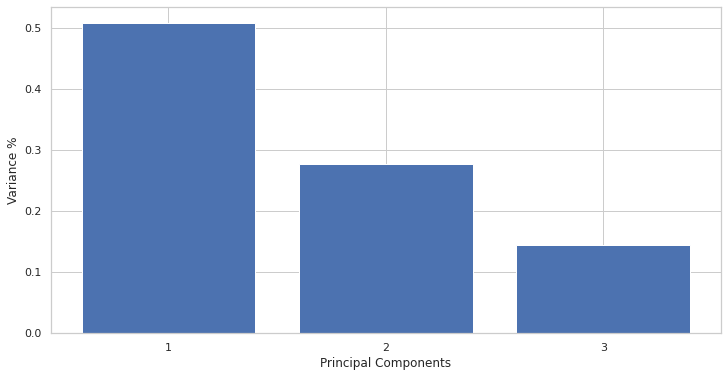

In [15]:
PC = range(1, pca_3.n_components_+1)
plt.figure(figsize=(12,6))
plt.bar(PC, pca_3.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC);
plt.show()

The three components explain 93% of the variance

In [16]:
pca_3.explained_variance_ratio_.sum()

0.9300261271042574

### Add the  three components  to the dataframe 

In [17]:
df = pd.concat([df, pd.DataFrame(data= pc_3, columns = ['PC1', 'PC2', 'PC3'])], axis=1)
df.head()

Month  DayofMonth  DayOfWeek  ...          PC1          PC2         PC3
0      1          21          1  ...  -147.787747  1276.742461 -184.202003
1      8          28          4  ... -1234.282139   944.410253  -19.965828
2     10          20          1  ...   498.194003  -393.948395  -80.868691
3      9          30          2  ...  -376.328326  -561.315613   24.344254
4      2           5          2  ...  -367.672972  -336.754195  -32.862216

[5 rows x 28 columns]

### Finding the optimal number of clusters

Using distortion metric, the best number of clusters for a Kmeans Model is 5


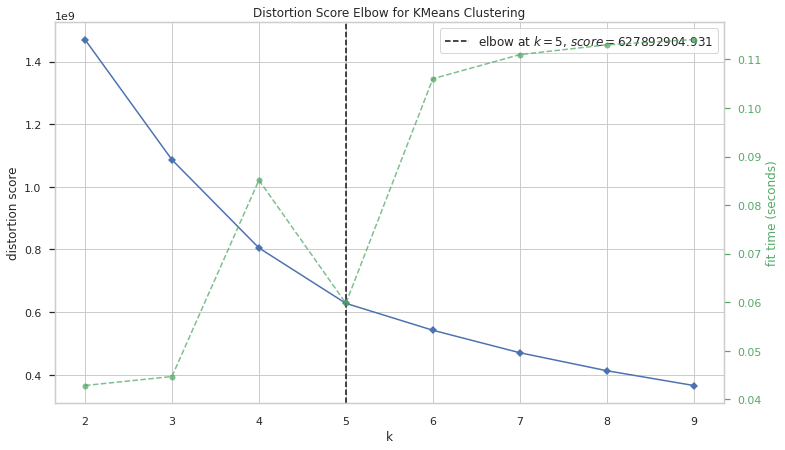

Using silhouette metric, the best number of clusters for a Kmeans Model is 4


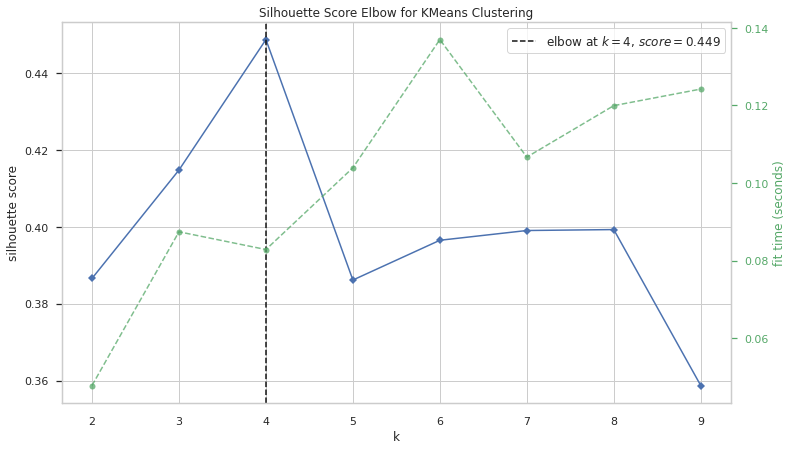

Using calinski_harabasz metric, the best number of clusters for a Kmeans Model is 2


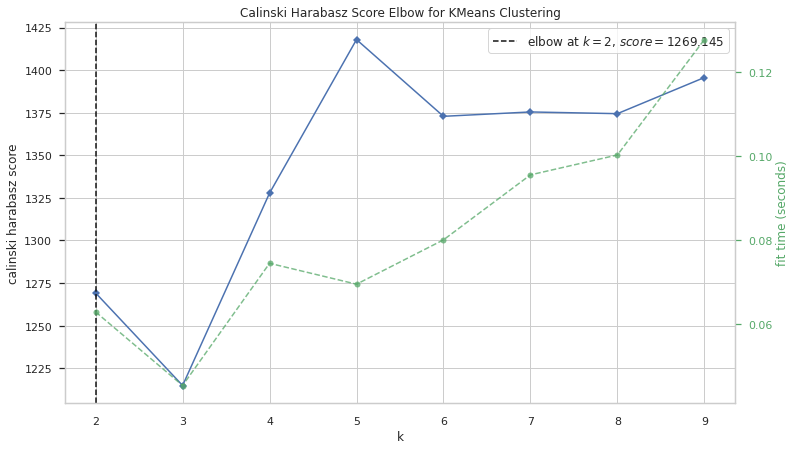

In [21]:
for i, metric in enumerate(['distortion','silhouette','calinski_harabasz']):
    visualizer = KElbowVisualizer(KMeans(), k=(2,10), metric=metric)
    visualizer.fit(df[['PC1', 'PC2', 'PC3']].values)
    print(r'Using {} metric, the best number of clusters for a Kmeans Model is {}'.format(metric, visualizer.elbow_value_))
    visualizer.show()

## Execute the Kmeans model with 5 Clusters and adjust it to the Components of the PCA

In [22]:
n5_k_means = KMeans(init = "k-means++", 
                 n_clusters = 5, 
                 n_init = 12, 
                 random_state= 130).fit(df[["PC1", "PC2", "PC3"]])

## Add the labels in the Dataframe

In [23]:
df = pd.concat([df, pd.DataFrame({'n5_kmeans_labels':n5_k_means.labels_})], axis=1)
df

Month  DayofMonth  DayOfWeek  ...          PC2         PC3  n5_kmeans_labels
0         1          21          1  ...  1276.742461 -184.202003                 3
1         8          28          4  ...   944.410253  -19.965828                 2
2        10          20          1  ...  -393.948395  -80.868691                 1
3         9          30          2  ...  -561.315613   24.344254                 1
4         2           5          2  ...  -336.754195  -32.862216                 1
...     ...         ...        ...  ...          ...         ...               ...
2016      5          15          4  ...    70.305054 -148.265753                 2
2017      5           4          7  ...  -203.287955 -146.252045                 4
2018      6          17          2  ...   290.153216 -296.766373                 4
2019     12          23          2  ...  -756.882364  -47.123207                 4
2020      6          12          4  ...    49.157377   -5.595227                 2

[2021 rows x 29 columns]

## Plot

### 3d scatterplot

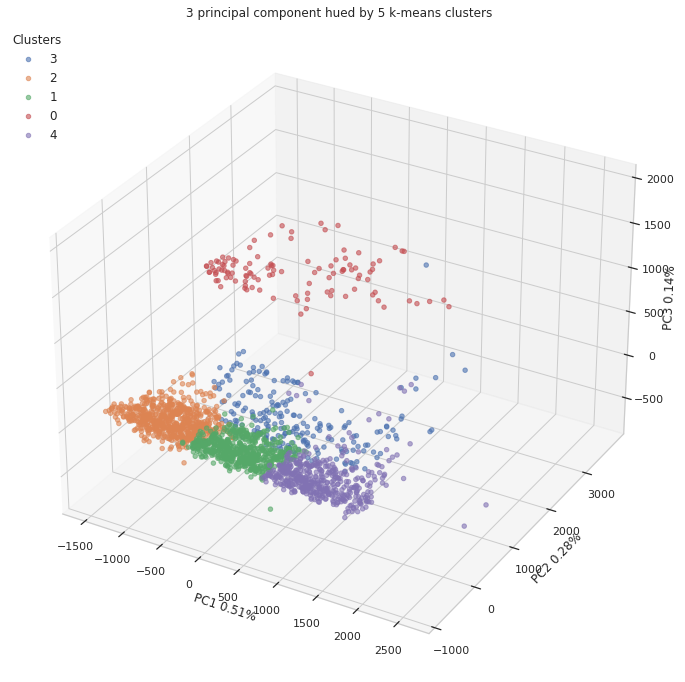

In [24]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

for s in df.n5_kmeans_labels.unique():
    ax.scatter(df.PC1[df.n5_kmeans_labels==s], 
                   df.PC2[df.n5_kmeans_labels==s], 
                   df.PC3[df.n5_kmeans_labels==s],
                   label=s, alpha=0.6)

ax.set(xlabel='PC1 '+str(round(pca_3.explained_variance_ratio_[0], 2))+"%",
          ylabel='PC2 '+str(round(pca_3.explained_variance_ratio_[1], 2))+"%",
          zlabel='PC3 '+str(round(pca_3.explained_variance_ratio_[2], 2))+"%",
          title= "{} principal component hued by {} k-means clusters".format(pca_3.n_components,5))
plt.legend(title="Clusters", fontsize=12,bbox_to_anchor=(0.09, 1))
plt.show()

### 3d scatterplot animation.

In [26]:
anim = animation.FuncAnimation(fig, animate, frames=360, interval=50)
HTML(anim.to_html5_video())

### Joy plot

 
<img src='https://lifradio.com/wp-content/uploads/2020/06/Joy-Diision-The-Indigo-Show-1400x800.jpg' width="500" height="300">

Ridgeline Plot or Joy Plot is a kind of chart that is used to visualize distributions of several groups of a category. Each category or group of a category produces a density curve overlapping with each other. Joyplot got its name from the album cover Unknown Pleasue by Joy Division in 1979.

<img src=''>

PC1                   ...                           
                  count     mean     std  ...      50%      75%      max
n5_kmeans_labels                          ...                           
0                 112.0   317.58  528.47  ...   105.99   575.02  1741.88
1                 601.0    63.18  277.47  ...    63.83   302.96   564.36
2                 631.0  -895.85  272.27  ...  -905.36  -666.69  -381.40
3                 217.0     2.13  631.77  ...   -73.06   482.85  1477.52
4                 460.0  1068.00  342.74  ...  1030.40  1299.64  2587.57

[5 rows x 8 columns]

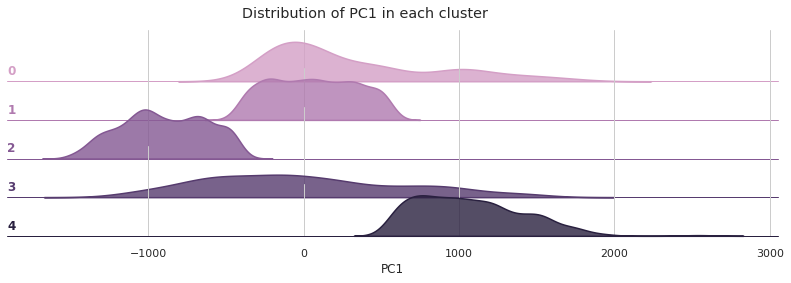

PC2                   ...                           
                  count     mean     std  ...      50%      75%      max
n5_kmeans_labels                          ...                           
0                 112.0   554.34  810.32  ...   317.32  1312.29  2244.81
1                 601.0  -217.07  306.81  ...  -262.49    27.24   483.63
2                 631.0  -128.16  338.28  ...  -183.27   123.74   944.41
3                 217.0  1161.60  504.36  ...  1043.20  1528.71  3768.27
4                 460.0  -223.54  387.53  ...  -293.18     7.14  1166.98

[5 rows x 8 columns]

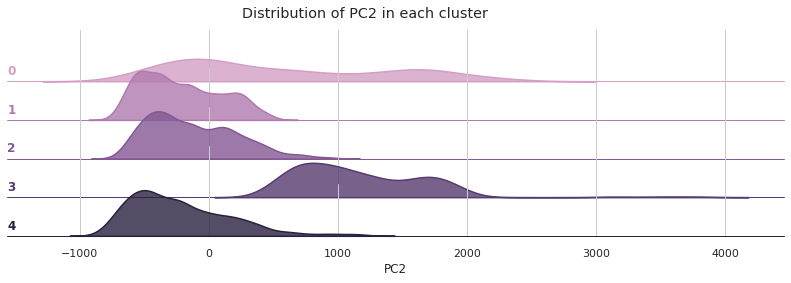

PC3                   ...                           
                  count     mean     std  ...      50%      75%      max
n5_kmeans_labels                          ...                           
0                 112.0  1643.86  231.70  ...  1707.56  1810.44  1950.29
1                 601.0   -76.87   93.66  ...   -61.91    -9.25   439.58
2                 631.0   -30.24   89.53  ...   -17.80    38.35   164.64
3                 217.0  -302.64  219.03  ...  -285.03  -157.17   865.20
4                 460.0  -115.56  160.92  ...  -116.17   -60.60   910.99

[5 rows x 8 columns]

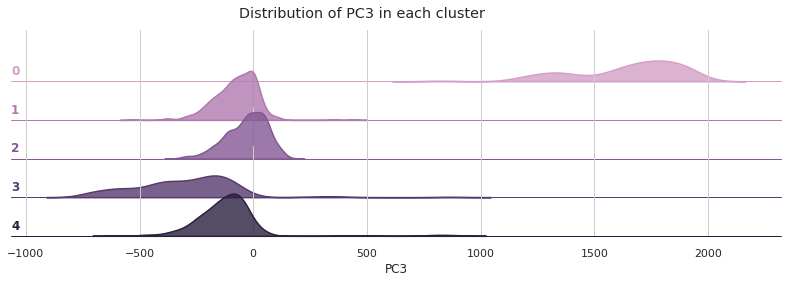

In [31]:
for col in ['PC1', 'PC2', 'PC3']:
    display(df.groupby(by="n5_kmeans_labels").describe().round(2)[[col]])
    plot_joy(df, col, "n5_kmeans_labels")
    plt.show()

# Exercise 2: 
  - Classify the different flights using the hierarchical clustering algorithm.

# Hierarchical Clustering

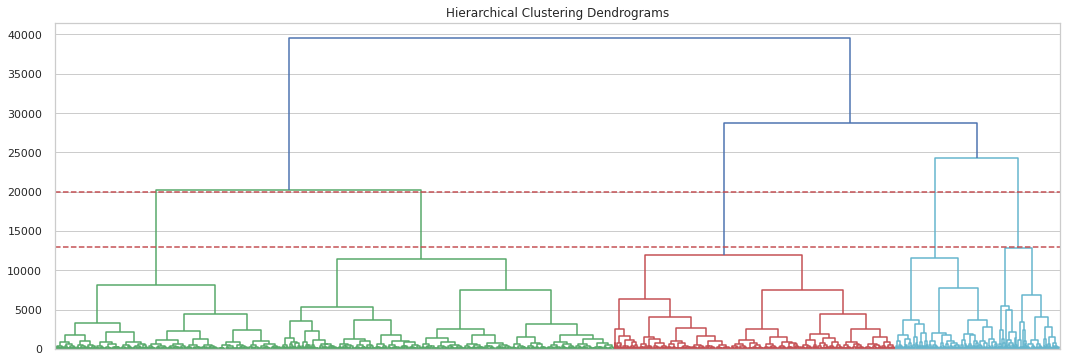

In [34]:
plt.figure(figsize=(18, 6)) 
plt.title("Hierarchical Clustering Dendrograms")  
dendrogram = sch.dendrogram(sch.linkage(df[['PC1', 'PC2', 'PC3']], method='ward'), no_labels=True)
plt.axhline(y= 20000, color='r', linestyle='--')
plt.axhline(y= 13000, color='r', linestyle='--')
plt.show()

## Execute the Agglomerative hierarchical clustering model with 5 Clusters and adjust it to the Components of the PCA

In [35]:
n5_agglomerative = AgglomerativeClustering(n_clusters= 5, affinity='euclidean', linkage='ward')
n5_agglomerative.fit(df[["PC1", "PC2", "PC3"]])
df["n5_Agglomerative_labels"] = n5_agglomerative.labels_
df.head()

Month  DayofMonth  ...  n5_kmeans_labels  n5_Agglomerative_labels
0      1          21  ...                 3                        1
1      8          28  ...                 2                        3
2     10          20  ...                 1                        2
3      9          30  ...                 1                        3
4      2           5  ...                 1                        4

[5 rows x 30 columns]

## Plot

### 3d scatterplot

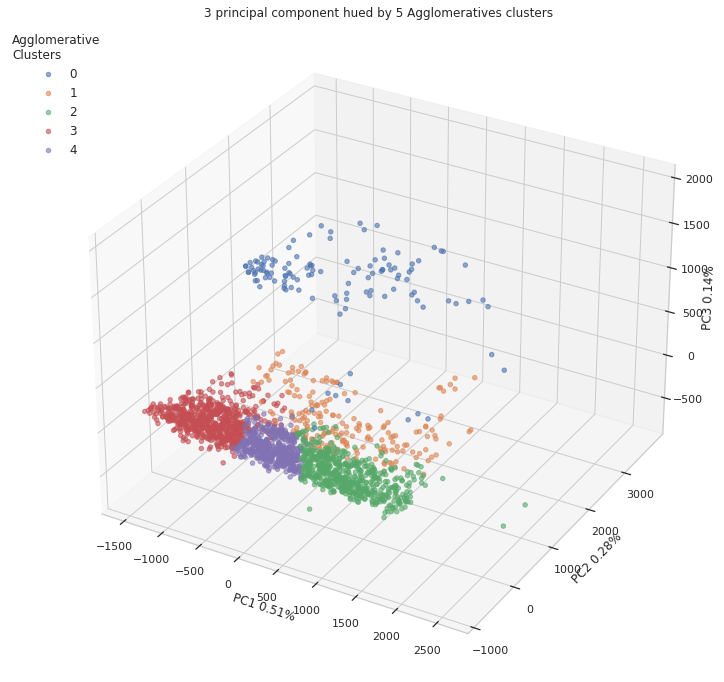

In [36]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

for s in list(range(n5_agglomerative.n_clusters)):
    ax.scatter(df.PC1[df.n5_Agglomerative_labels==s], 
                   df.PC2[df.n5_Agglomerative_labels==s], 
                   df.PC3[df.n5_Agglomerative_labels==s],
                   label=s, alpha=0.6)

ax.set(xlabel='PC1 '+str(round(pca_3.explained_variance_ratio_[0], 2))+"%",
          ylabel='PC2 '+str(round(pca_3.explained_variance_ratio_[1], 2))+"%",
          zlabel='PC3 '+str(round(pca_3.explained_variance_ratio_[2], 2))+"%",
          title= "{} principal component hued by {} Agglomeratives clusters".format(pca_3.n_components,n5_agglomerative.n_clusters))
plt.legend(title="Agglomerative\nClusters", fontsize=12,bbox_to_anchor=(0.09, 1))
plt.show()

### 3d scatterplot animation.

In [42]:
anim = animation.FuncAnimation(fig, animate, frames=360, interval=50)
HTML(anim.to_html5_video())

### Joy plot

PC1                  ...                          
                         count    mean     std  ...     50%      75%      max
n5_Agglomerative_labels                         ...                          
0                        124.0  389.22  570.48  ...  153.48   795.90  1945.28
1                        206.0  138.59  682.48  ...   57.81   634.31  1527.63
2                        566.0  904.01  419.72  ...  875.08  1198.43  2587.57
3                        669.0 -870.19  287.08  ... -874.88  -644.14  -321.76
4                        456.0  -13.88  242.44  ...  -27.37   175.89   534.93

[5 rows x 8 columns]

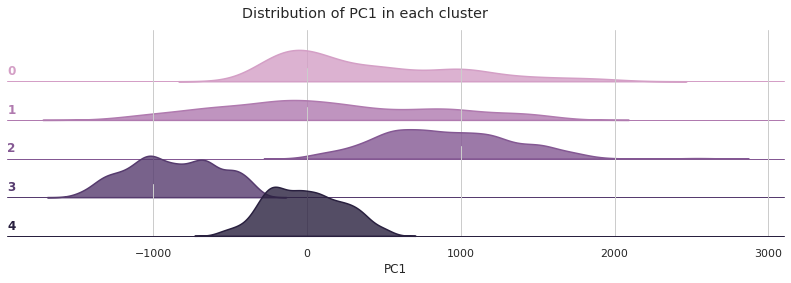

PC2                   ...                           
                         count     mean     std  ...      50%      75%      max
n5_Agglomerative_labels                          ...                           
0                        124.0   560.11  927.39  ...   163.46  1312.29  3768.27
1                        206.0  1153.51  419.79  ...  1070.64  1525.14  2005.92
2                        566.0  -186.99  348.90  ...  -218.03   120.02  1107.81
3                        669.0  -123.15  371.60  ...  -208.91   138.60  1013.05
4                        456.0  -260.64  286.63  ...  -319.42   -25.72   483.63

[5 rows x 8 columns]

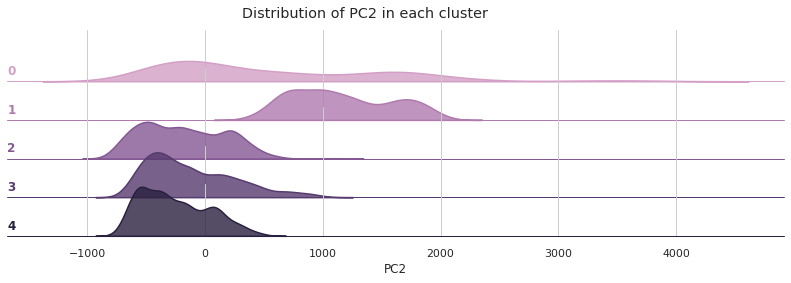

PC3                   ...                           
                         count     mean     std  ...      50%      75%      max
n5_Agglomerative_labels                          ...                           
0                        124.0  1538.84  415.76  ...  1674.42  1800.74  1950.29
1                        206.0  -303.95  225.31  ...  -285.69  -161.66   498.85
2                        566.0  -134.70   95.65  ...  -121.86   -67.82    62.74
3                        669.0   -33.46   95.13  ...   -17.91    35.47   164.64
4                        456.0   -64.86   78.95  ...   -51.68    -5.98   117.47

[5 rows x 8 columns]

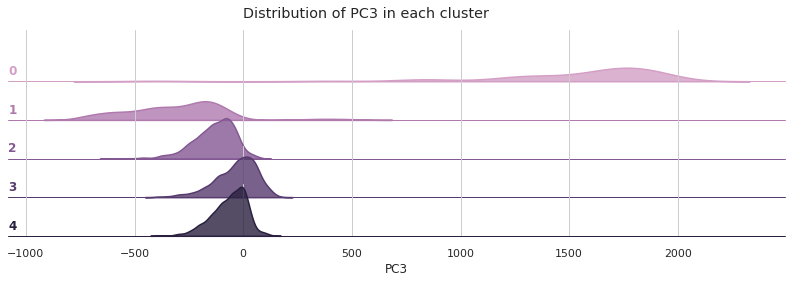

In [37]:
for col in ['PC1', 'PC2', 'PC3']:
    display(df.groupby(by="n5_Agglomerative_labels").describe().round(2)[[col]])
    plot_joy(df, col, "n5_Agglomerative_labels")
    plt.show()

# Exercise 3: 

Calculate clustering performance using a parameter such as silhouette.

## Silhouette

In [38]:
n5_k_means_silhouette = silhouette_score(df[["PC1", "PC2", "PC3"]], n5_k_means.labels_).round(3)
n5_k_means_silhouette

0.386

In [39]:
n5_agglomerative_silhouette = silhouette_score(df[["PC1", "PC2", "PC3"]], n5_agglomerative.labels_).round(3)
n5_agglomerative_silhouette

0.334

## Calinski-Harabasz

In [40]:
n5_k_means_calinski_harabasz = calinski_harabasz_score(df[["PC1", "PC2", "PC3"]],  n5_k_means.labels_)
n5_k_means_calinski_harabasz

1417.9330568225125

In [41]:
n5_agglomerative_calinski_harabasz = calinski_harabasz_score(df[["PC1", "PC2", "PC3"]],  n5_agglomerative.labels_)
n5_agglomerative_calinski_harabasz

1212.8895491076323

Both Silhouette and Calinski - Harabasz indicate that the best performance is achieved by KMeans

